# Configuration

In [34]:
fractionOfData = 1

# Import

In [146]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

# Helper functions

In [104]:
%run utils.py

# Load data

## Metadata

In [105]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')

In [106]:
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'

In [107]:
metaData = pd.concat([metaData_apartment, metaData_building])

In [108]:
metaDataDict = {}
for index, row in metaData.iterrows():
    metaDataDict[row['name']] = {'type':list(row)[1], 'categories':list(row)[3]}

In [109]:
metaDataDict['seller']

{'type': 'categorical',
 'categories': ['Owner', 'Company', 'Agents', 'Developer']}

In [110]:
metaDataDict['apartment_id']['categories']

nan

## Train data

In [111]:
train_apartment = pd.read_csv('../data/apartments_train.csv')

In [112]:
train_building = pd.read_csv('../data/buildings_train.csv')

In [113]:
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [114]:
# Reduce amount of data for performance reasons during implementation.
train = train.head(int(train.shape[0] * fractionOfData))
train.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


## Test data

In [115]:
test_apartment = pd.read_csv('../data/apartments_test.csv')

In [116]:
test_building = pd.read_csv('../data/buildings_test.csv')

In [118]:
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test = train.head(int(train.shape[0] * fractionOfData))
test.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


# Initial simple test
## Data processing
We want to do a simple test where we only use area_total, ceiling and rooms.
We need to do something about the nan-values. First lets check if there are any, and how severe the situation is.

In [175]:
simple_train = train[['apartment_id','area_total','ceiling','rooms', 'price']]
simple_test = test[['apartment_id','area_total','ceiling','rooms']]

In [176]:
# If we found nan-values in price, we couldn't use it as training data.
print("Is all training data labeled? ", end="")
print(len(simple_train['price'].dropna()) == len(simple_train['price']))

Is all training data labeled? True


In [177]:
#Now, what about the features?
print(len(simple_train['area_total'].dropna()) == len(simple_train['area_total']))
print(len(simple_train['ceiling'].dropna()) == len(simple_train['ceiling']))
print(len(simple_train['rooms'].dropna()) == len(simple_train['rooms']))

True
False
True


In [178]:
print(len(simple_train['ceiling'].dropna()), len(simple_train['ceiling']))
print(simple_train['ceiling'].mean())

12192 23285
3.2683735236220475


In [179]:
# Alright, then we need to fix ceilings. Lets just drop all values with nan, or replace them with mean.
#simple_train = simple_train.dropna()
simple_train=simple_train.fillna(simple_train.mean())
simple_test=simple_test.fillna(simple_test.mean())

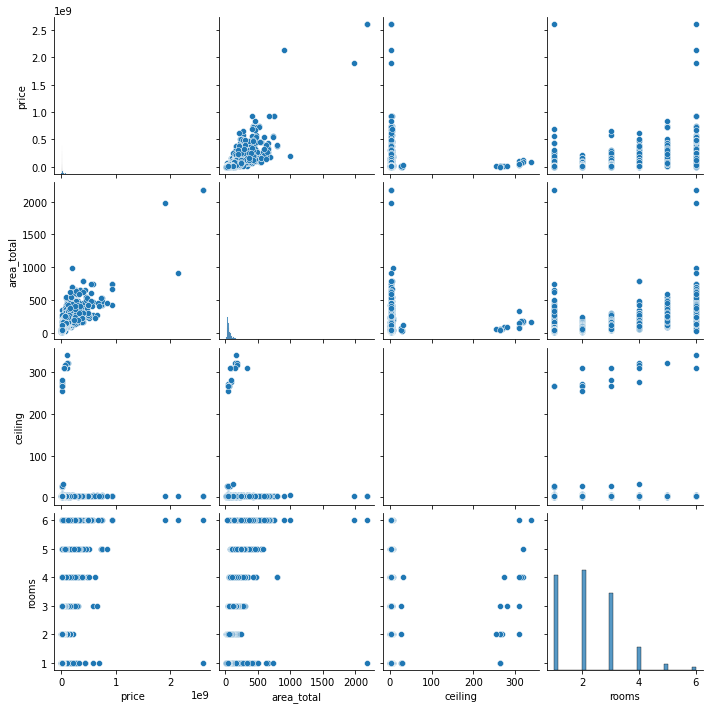

In [96]:
sns.pairplot(simple_train[['price', 'area_total', 'ceiling', 'rooms']])

## Training
Using a sequential deep ANN model to extraxt and train on features.

In [133]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [166]:
# Split data into labels and features. Normalize feature data.
simple_train_labels = simple_train['price']
simple_train_features = simple_train[['area_total','ceiling','rooms']]

In [185]:
# Model
model = tf.keras.Sequential([
    Dense(6, activation=tf.nn.relu, input_shape=[3]),
    Dense(6, activation=tf.nn.relu),
    Dense(1)
])
model.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredLogarithmicError, #mse
              metrics=['mae', 'mse', 'msle']) #-msle


In [163]:
# Train
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history = model.fit(simple_train_features, simple_train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])




....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [164]:
# Reults
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


# show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))

print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))
hist.tail()

Final Root Mean Square Error on validation set: 17344643.43


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,8.386665e+14,10135608.0,8.386665e+14,3.010952e+14,6151397.0,3.010952e+14,995
996,8.385477e+14,10152115.0,8.385477e+14,3.009332e+14,6146323.0,3.009332e+14,996
997,8.385822e+14,10142568.0,8.385822e+14,3.008354e+14,6143166.0,3.008354e+14,997
998,8.385151e+14,10148669.0,8.385151e+14,3.007746e+14,6141073.5,3.007746e+14,998
999,8.385735e+14,10131827.0,8.385735e+14,3.008367e+14,6142693.0,3.008367e+14,999


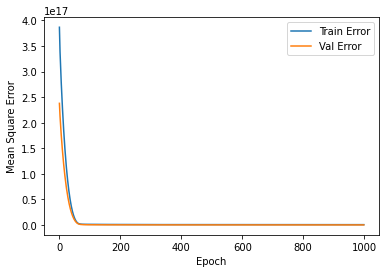

In [165]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()

plot_history()

In [197]:
# Second model: using MSLE instead of mse! Less sensitive to outlayers.
# Model
model2 = tf.keras.Sequential([
    Dense(6, activation=tf.nn.relu, input_shape=[3]),
    Dense(6, activation=tf.nn.relu),
    Dense(1)
])
model2.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredLogarithmicError(), #mse
              metrics=['mae', 'mse', 'msle']) #-msle


In [201]:
history = model2.fit(simple_train_features, simple_train_labels, epochs=300, verbose=0, validation_split = 0.1,
                    callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................

In [202]:
# Reults
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


# show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))

print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))
hist.tail()

Final Root Mean Square Error on validation set: 21715932.051


,loss,mae,mse,msle,val_loss,val_mae,val_mse,val_msle,epoch
295,0.209480,11038666.0,1.859907e+15,0.209480,0.135380,5545179.0,4.721428e+14,0.135380,295
296,0.209422,11034050.0,1.856949e+15,0.209422,0.135281,5542836.5,4.720968e+14,0.135281,296
297,0.209363,11032847.0,1.857393e+15,0.209363,0.135222,5541223.5,4.719961e+14,0.135222,297
298,0.209301,11031494.0,1.857694e+15,0.209301,0.135339,5542801.0,4.716373e+14,0.135339,298
299,0.209244,11027755.0,1.855762e+15,0.209244,0.135247,5540583.0,4.715817e+14,0.135247,299


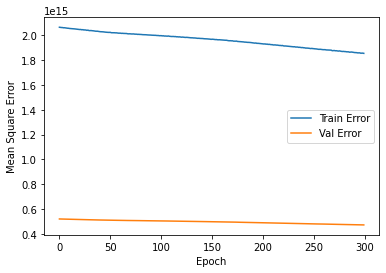

In [203]:
plot_history()

## Predicting / inference
Lets see how well our model does in the competition!

In [181]:
result = model.predict(simple_test[['area_total','ceiling','rooms']])

In [182]:
result

array([[1.3375417e+07],
       [6.4026460e+03],
       [2.0629982e+07],
       ...,
       [1.2705064e+07],
       [3.8919472e+07],
       [9.8013530e+06]], dtype=float32)